In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def import_velocities(filename):
    t, vx, vy, vz = np.loadtxt(filename, unpack = True)
    return t, np.asarray([vx, vy, vz]).transpose()

$$
c(\tau) = \langle \vec v(t)\cdot\vec v(t+\tau)\rangle 
$$

In [3]:
def compute_vacf(velocities):
    N = len(velocities)
    vacf = np.zeros(N)
    for tau in range(N):
        #print(f"step {tau}/{N}")
        dot_products = np.sum(velocities[:N - tau] * velocities[tau:], axis=1)
        vacf[tau] = np.mean(dot_products)
    return vacf

In [4]:
def compute_vacf_einsum(velocities):
    N = len(velocities)
    vacf = np.array([
        np.einsum('ij,ij->', velocities[:-tau], velocities[tau:]) / (N - tau)
        if tau > 0 else np.einsum('ij,ij->', velocities, velocities) / N
        for tau in range(N)
    ])
    return vacf / vacf[0]


In [ ]:
def compute_vacf_fft(velocities):
    N = velocities.shape[0]
    
    # Flatten velocity vectors into 1D signals per component
    v = velocities.T  # Shape (3, N)

    # Compute VACF per component
    vacf_components = []
    for comp in v:
        # Zero-pad to 2N to avoid circular convolution
        f = np.fft.fft(comp, n = 2*N,) # compute frequency spectrum
        ps = f * np.conj(f) # compute power spectrum
        ac = np.fft.ifft(ps).real[:N]
        ac /= np.arange(N, 0, -1)  # Normalize by number of contributing terms
        vacf_components.append(ac)

    vacf = sum(vacf_components)  # Sum over x, y, z components
    return vacf / vacf[0]  # normalize

In [7]:
from time import time

def time_func(say = "Executed"):
    def decorator(func):
        def wrapper(*args, **kwargs):
            start = time()
            value = func(*args, **kwargs)
            end = time()
            print(f"{say} in {end-start} seconds....")
            return value
        return wrapper
    return decorator

In [8]:
@time_func(say = "Computed VACF")
def time_vacf_fft(velocities):
    value = compute_vacf_fft(velocities)
    return value

$$
D = \frac13 \int_0^\infty {\rm d}t\ c(t)
$$

In [9]:
def compute_D(t, vacf, cutoff = 1000):
    dt = np.diff(t)
    D = vacf[:cutoff] @ dt[:cutoff]

    return D

In [10]:
def compute_MSD(D, t):
    return 6*D*t

In [115]:
def compute_MSD_numerical(t, velocities, cutoff = 20000):
    dt = np.diff(t)[:cutoff]
    velocities = velocities[:cutoff] 
    N = len(velocities)

    positions = np.zeros((N, 3))
    for i in range(1, N):
        vel = velocities[i-1]
        if i == 1:
            positions[i] = vel * dt[i-1]
            continue
        positions[i] = positions[i-1] + vel * dt[i-1]

    msd = np.zeros(N)
    for i in range(1, N):
        msd[i] = np.mean(np.sum((positions[:N-i] - positions[i:])**2, axis=1))

    return t[:cutoff], msd[:cutoff]

@time_func(say = "Computed MSD")
def time_MSD_numerical(t, velocities, cutoff = 20000):
    value = compute_MSD_numerical(t, velocities, cutoff)
    return value

In [11]:
t0, v0 = import_velocities("velocity_trajs/v_0.dat")
t1, v1 = import_velocities("velocity_trajs/v_1.dat")
t2, v2 = import_velocities("velocity_trajs/v_2.dat")

Computed VACF in 0.23088860511779785 seconds....
Computed MSD in 1.377748966217041 seconds....


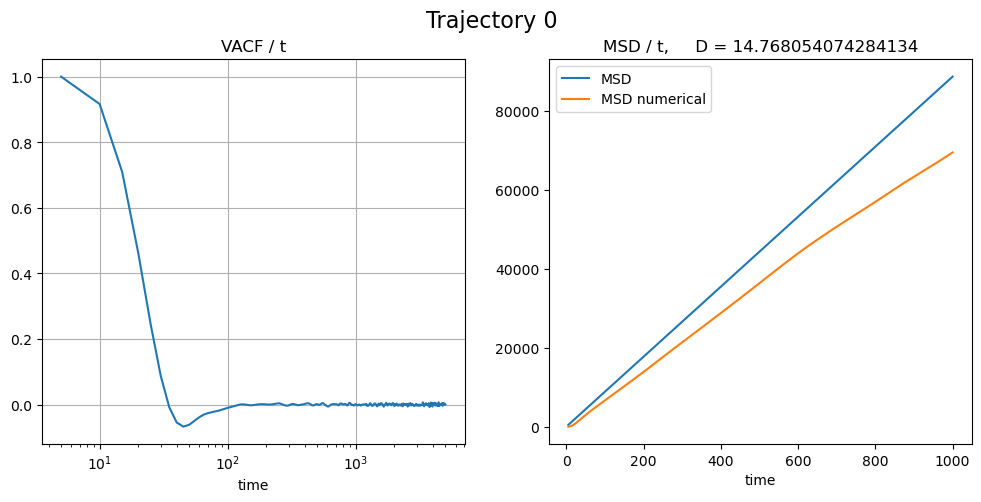

Computed VACF in 0.18571019172668457 seconds....
Computed MSD in 1.1850409507751465 seconds....


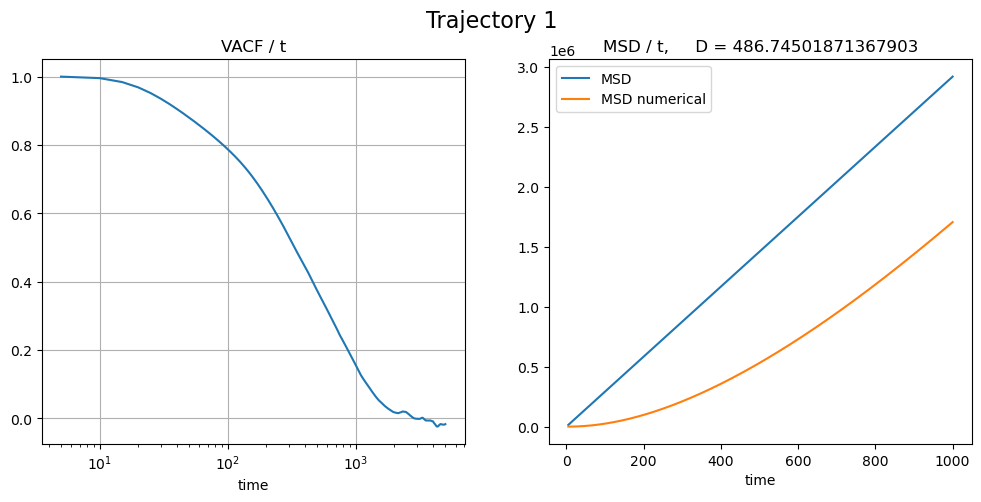

Computed VACF in 0.2173771858215332 seconds....
Computed MSD in 1.1116971969604492 seconds....


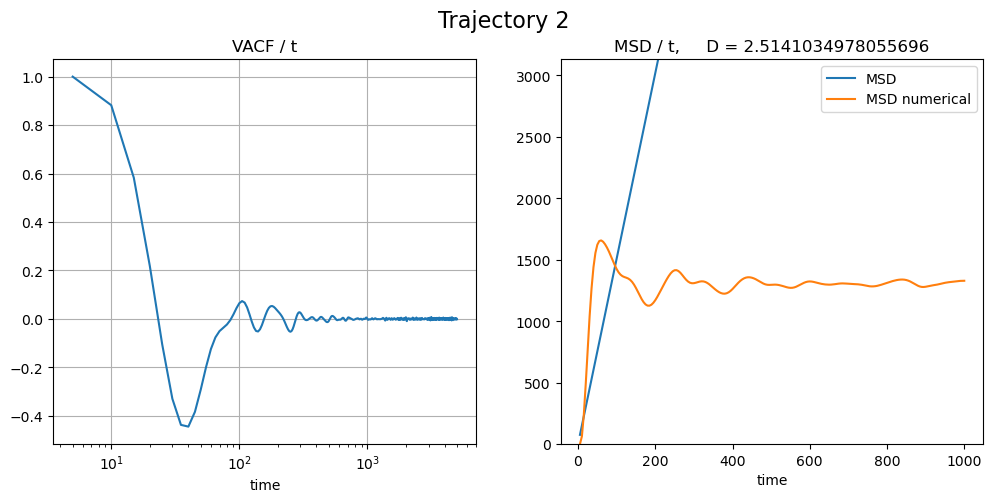

In [125]:
j = 0 # increments in loop

for i in [(t0, v0), (t1, v1), (t2, v2)]:
    t, v = i

    cutin = 0
    cutoff = 1000

    vacf = time_vacf_fft(v)
    D = compute_D(t, vacf, cutoff = 1000)
    MSD = compute_MSD(D, t)
    t_msd, MSD_numerical = time_MSD_numerical(t, v, cutoff = 10000)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].semilogx(t[cutin:cutoff], vacf[cutin:cutoff])
    axs[0].set_xlabel("time")
    axs[0].set_title("VACF / t")
    axs[0].grid()

    cutoff = 200

    axs[1].plot(t[cutin:cutoff], MSD[cutin:cutoff], label = "MSD")
    axs[1].plot(t[cutin:cutoff], MSD_numerical[cutin:cutoff], label = "MSD numerical")
    axs[1].set_xlabel("time")
    axs[1].set_title(f"MSD / t,     D = {D}")
    axs[1].legend()
    #axs[1].set_ylim(0, min(max(MSD), 1.5*max(MSD_numerical)))
    if j == 2:
        axs[1].set_ylim(0, 1.5*max(MSD_numerical))

    fig.suptitle(f"Trajectory {j}", fontsize = 16)
    plt.show()

    j += 1

